# Customer Segmentation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [3]:
# load and test
# Load datasets
customers_path = 'Customers.csv'
transactions_path = 'Transactions.csv'

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

print(customers_df.head(3))
print("\n")
print(transactions_df.head(3))

  CustomerID      CustomerName         Region  SignupDate
0      C0001  Lawrence Carroll  South America  2022-07-10
1      C0002    Elizabeth Lutz           Asia  2022-02-13
2      C0003    Michael Rivera  South America  2024-03-07


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  


In [4]:
# Merging datasets for analysis
merged_data = transactions_df.merge(customers_df, on='CustomerID')

In [5]:
# Feature engineering
# Aggregating transactional data per customer
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum',    # Total quantity purchased
    'TransactionID': 'count'  # Number of transactions
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()


In [6]:
# Adding customer profile data
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['SignupDays'] = (customers_df['SignupDate'] - customers_df['SignupDate'].min()).dt.days
customer_features = customer_features.merge(
    customers_df[['CustomerID', 'Region', 'SignupDays']], on='CustomerID', how='left'
)


In [7]:
# One-hot encoding for Region (categorical variable)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)


In [8]:
# Standardizing the features
scaler = StandardScaler()
numerical_columns = ['TotalValue', 'Quantity', 'TransactionCount', 'SignupDays']
customer_features[numerical_columns] = scaler.fit_transform(customer_features[numerical_columns])


In [9]:
# Clustering
optimal_clusters = None
optimal_db_index = float('inf')
cluster_results = {}

In [10]:
# Test clusters between 2 and 10
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(customer_features[numerical_columns])
    db_index = davies_bouldin_score(customer_features[numerical_columns], customer_features['Cluster'])
    cluster_results[n_clusters] = db_index

    if db_index < optimal_db_index:
        optimal_clusters = n_clusters
        optimal_db_index = db_index

In [11]:
# Run KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numerical_columns])

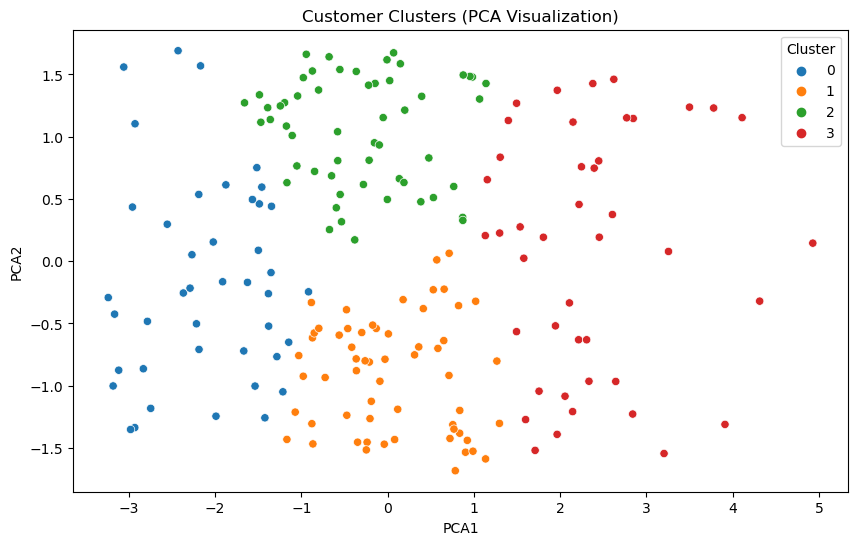

In [12]:
# Visualizing clusters using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(customer_features[numerical_columns])
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='tab10', data=customer_features, legend='full'
)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [13]:
# Display clustering metrics
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index for optimal clusters: {optimal_db_index:.2f}")


Optimal number of clusters: 4
Davies-Bouldin Index for optimal clusters: 0.92


In [15]:
#extra 
# Save the clustered data to another csv.
output_path = 'Customer_Clusters.csv'
customer_features.to_csv(output_path, index=False)
print(f"Clustered data saved to: {output_path}")

Clustered data saved to: Customer_Clusters.csv
